In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!unzip -q "/content/MyDrive/MyDrive/UMHackathon/UMHackathon 2021 Finance Dataset.zip" -d "dataset" 

In [ ]:
import pandas as pd
import glob
import os
import dateutil.parser
import functools
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime
import random

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning

In [ ]:
dataset_dir = "/content/dataset/BPAM Evaluated Prices Rated Range Prices (LT)"

def read_all_csvs(dataset_dir):
  sub_dirs = [f for f in os.listdir(dataset_dir) if not os.path.isfile(f)]
  df_BPAMERP = pd.DataFrame()
  df_BPAMERS = pd.DataFrame()
  df_joined = pd.DataFrame()
  for sub_dir in sub_dirs:
    full_path = os.path.join(dataset_dir, sub_dir)
    for file_name in os.listdir(full_path):
      full_file_name = os.path.join(full_path, file_name)
      if "BPAMERP" in file_name:
        temp_df_BPAMERP =  pd.read_csv(full_file_name, parse_dates=True)
        df_BPAMERP = pd.concat([df_BPAMERP, temp_df_BPAMERP])
      elif "BPAMERS" in file_name:
        temp_df_BPAMERS =  pd.read_csv(full_file_name, parse_dates=True)
        df_BPAMERS = pd.concat([df_BPAMERS, temp_df_BPAMERS])
    df_joined = pd.concat([df_joined, temp_df_BPAMERP.merge(temp_df_BPAMERS, on = ['STOCK CODE','ISIN CODE','STOCK NAME'], how = 'inner')])
  return df_BPAMERP.reset_index(drop=True), df_BPAMERS.reset_index(drop=True), df_joined.sort_values(by=['VALUE DATE']).reset_index(drop=True)

df_BPAMERP, df_BPAMERS, df_joined = read_all_csvs(dataset_dir)
df_joined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34206 entries, 0 to 34205
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   STOCK CODE                                34206 non-null  object 
 1   ISIN CODE                                 34206 non-null  object 
 2   STOCK NAME                                34206 non-null  object 
 3   VALUE DATE                                34206 non-null  object 
 4   EVAL UPPER THRESHOLD YIELD                34206 non-null  float64
 5   EVAL MID YIELD                            34206 non-null  float64
 6   EVAL LOWER THRESHOLD YIELD                34206 non-null  float64
 7   EVAL LOWER THRESHOLD PRICE                34206 non-null  float64
 8   EVAL MID PRICE                            34206 non-null  float64
 9   EVAL UPPER THRESHOLD PRICE                34206 non-null  float64
 10  MODIFIED DURATION                 

In [ ]:
# parse datetime data type
date_columns = [column for column in df_joined.columns if "DATE" in column]
for date_column in date_columns:
  df_joined[date_column] = pd.to_datetime(df_joined[date_column], infer_datetime_format=True)  

# parse bool data type
d = {'Y': True, 'N': False}
df_joined["CALLABLE/PUTTABLE"] = df_joined["CALLABLE/PUTTABLE"].map(d)
df_joined["CONVERTIBLE/EXCHANGABLE"] = df_joined["CONVERTIBLE/EXCHANGABLE"].map(d)

# parse category data type
obj_columns = df_joined.select_dtypes(include='object').columns
for obj_column in obj_columns:
  df_joined[obj_column] = df_joined[obj_column].astype('category')

# show the memory usage
df_joined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34206 entries, 0 to 34205
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   STOCK CODE                                34206 non-null  category      
 1   ISIN CODE                                 34206 non-null  category      
 2   STOCK NAME                                34206 non-null  category      
 3   VALUE DATE                                34206 non-null  datetime64[ns]
 4   EVAL UPPER THRESHOLD YIELD                34206 non-null  float64       
 5   EVAL MID YIELD                            34206 non-null  float64       
 6   EVAL LOWER THRESHOLD YIELD                34206 non-null  float64       
 7   EVAL LOWER THRESHOLD PRICE                34206 non-null  float64       
 8   EVAL MID PRICE                            34206 non-null  float64       
 9   EVAL UPPER THRESHOLD PRICE  

In [ ]:
# impute null value
df_joined.isnull().sum().sort_values()

STOCK CODE                                      0
PRINCIPLE                                       0
BOND TYPE                                       0
BOND CLASS                                      0
CONVERTIBLE/EXCHANGABLE                         0
ISSUE DATE                                      0
MATURITY DATE                                   0
DAY COUNT BASIS                                 0
ISSUER NAME                                     0
FACILITY AMOUNT/FACILITY LIMIT(MYR MIL)         0
BOND ISSUE AMOUNT(MYR MIL)                      0
BOND CURRENT OUTSTANDING AMOUNT(MYR MIL)        0
REMAINING TENURE                                0
ISSUER FACILITY LIMIT(MYR MIL)                  0
ISSUER OUTSTANDING AMOUNT(MYR MIL)              0
SECTOR                                          0
CALLABLE/PUTTABLE                               0
FACILITY OUTSTANDING AMOUNT(MYR MIL)            0
FACILITY CODE                                   0
RATING                                          0


In [ ]:
df_joined["COUPON FREQUENCY"].fillna(0, inplace = True)
df_joined["NEXT COUPON RATE"].fillna(0, inplace = True)
df_joined["PREVIOUS COUPON RATE"].fillna(0, inplace = True)

In [ ]:
# impute null value
df_joined.isnull().sum().sort_values()

STOCK CODE                                      0
BOND CLASS                                      0
CONVERTIBLE/EXCHANGABLE                         0
ISSUE DATE                                      0
MATURITY DATE                                   0
DAY COUNT BASIS                                 0
COUPON FREQUENCY                                0
PREVIOUS COUPON RATE                            0
NEXT COUPON RATE                                0
FACILITY AMOUNT/FACILITY LIMIT(MYR MIL)         0
FACILITY OUTSTANDING AMOUNT(MYR MIL)            0
BOND ISSUE AMOUNT(MYR MIL)                      0
BOND CURRENT OUTSTANDING AMOUNT(MYR MIL)        0
REMAINING TENURE                                0
ISSUER FACILITY LIMIT(MYR MIL)                  0
ISSUER OUTSTANDING AMOUNT(MYR MIL)              0
SECTOR                                          0
CALLABLE/PUTTABLE                               0
BOND TYPE                                       0
PRINCIPLE                                       0


In [ ]:
# show the unique values of each categorical column
cat_columns = df_joined.select_dtypes(include='category').columns
for col in cat_columns:
  print(f"{col} has {len(pd.unique(df_joined[col]))}")
  print(pd.unique(df_joined[col]))
  print("-"*100)

STOCK CODE has 2519
['VI190212', 'VP120268', 'VP120267', 'VP120266', 'VP120265', ..., 'VH200282', 'VN200229', 'MO200002', 'VG200271', 'VE200222']
Length: 2519
Categories (2519, object): ['VI190212', 'VP120268', 'VP120267', 'VP120266', ..., 'VN200229',
                            'MO200002', 'VG200271', 'VE200222']
----------------------------------------------------------------------------------------------------
ISIN CODE has 2519
['MYBVI1902128', 'MYBVP1202680', 'MYBVP1202672', 'MYBVP1202664', 'MYBVP1202656', ..., 'MYBVH2002821', 'MYBVN2002290', 'MYBMO2000028', 'MYBVG2002716', 'MYBVE2002224']
Length: 2519
Categories (2519, object): ['MYBVI1902128', 'MYBVP1202680', 'MYBVP1202672', 'MYBVP1202664', ...,
                            'MYBVN2002290', 'MYBMO2000028', 'MYBVG2002716', 'MYBVE2002224']
----------------------------------------------------------------------------------------------------
STOCK NAME has 2474
['PRESS METAL IMTN 4.100% 17.10.2024', 'ARSB IMTN 5.600% 12.07.2024 - Class

In [ ]:
df_joined.head(5)

,STOCK CODE,ISIN CODE,STOCK NAME,VALUE DATE,EVAL UPPER THRESHOLD YIELD,EVAL MID YIELD,EVAL LOWER THRESHOLD YIELD,EVAL LOWER THRESHOLD PRICE,EVAL MID PRICE,EVAL UPPER THRESHOLD PRICE,MODIFIED DURATION,CONVEXITY,EVAL UPPER THRESHOLD YIELD CHANGE,EVAL MID YIELD CHANGE,EVAL LOWER THRESHOLD YIELD CHANGE,EVAL LOWER THRESHOLD PRICE CHANGE,EVAL MID PRICE CHANGE,EVAL UPPER THRESHOLD PRICE CHANGE,COMPOSITE LIQUIDITY SCORE (T-1),FACILITY CODE,ISSUER NAME,PRINCIPLE,BOND TYPE,BOND CLASS,RATING,RATING AGENCY,ISSUE DATE,MATURITY DATE,EXPECTED MATURITY DATE,DAY COUNT BASIS,COUPON FREQUENCY,FIRST PAYMENT DATE,PREVIOUS PAYMENT DATE,PREVIOUS COUPON RATE,NEXT PAYMENT DATE,NEXT COUPON RATE,FACILITY AMOUNT/FACILITY LIMIT(MYR MIL),FACILITY OUTSTANDING AMOUNT(MYR MIL),BOND ISSUE AMOUNT(MYR MIL),BOND CURRENT OUTSTANDING AMOUNT(MYR MIL),REMAINING TENURE,ISSUER FACILITY LIMIT(MYR MIL),ISSUER OUTSTANDING AMOUNT(MYR MIL),ISLAMIC CONCEPT,SECTOR,RATING EFFECTIVE DATE,CALLABLE/PUTTABLE,CONVERTIBLE/EXCHANGABLE,RATING ACTION
0,VI190212,MYBVI1902128,PRESS METAL IMTN 4.100% 17.10.2024,2020-04-01,4.341,4.232,4.123,99.014,99.458,99.904,4.027,19.339,-0.021,-0.022,-0.023,0.086,0.090,0.095,0.0,201900058,Press Metal Aluminium Holdings Berhad,ISLAMIC,Fixed Rate Bond,Corporate,AA3,RAM,2019-10-17,2024-10-17,NaT,ACT365,2.0,2020-04-17,NaT,0.00,2020-04-17,4.10,5000,1000,550,550,5Y,5000,1000,MURABAHAH + WAKALAH,DIVERSIFIED HOLDINGS,2019-08-23,False,False,Initial
1,VP120268,MYBVP1202680,ARSB IMTN 5.600% 12.07.2024 - Class D,2020-04-01,4.365,4.256,4.147,102.648,102.887,103.126,2.107,5.645,-0.029,-0.030,-0.031,0.061,0.063,0.065,0.0,201200037,Axis REIT Sukuk Berhad,ISLAMIC,Callable Stepping Bond,Corporate,AA3,RAM,2012-07-13,2024-07-12,2022-07-13,ACT365,2.0,2013-01-14,2020-01-13,5.60,2020-07-13,5.60,5,5,5,5,5Y,635,420,MURABAHAH,PROPERTY AND REAL ESTATE,2019-10-02,True,False,Reaffirm
2,VP120267,MYBVP1202672,ARSB IMTN 5.300% 12.07.2024 - Class C,2020-04-01,4.100,4.008,3.916,102.583,102.785,102.987,2.116,5.680,-0.031,-0.031,-0.031,0.065,0.065,0.065,0.0,201200038,Axis REIT Sukuk Berhad,ISLAMIC,Callable Stepping Bond,Corporate,AA2,RAM,2012-07-13,2024-07-12,2022-07-13,ACT365,2.0,2013-01-14,2020-01-13,5.30,2020-07-13,5.30,5,5,5,5,5Y,635,420,MURABAHAH,PROPERTY AND REAL ESTATE,2019-10-02,True,False,Reaffirm
3,VP120266,MYBVP1202664,ARSB IMTN 4.950% 12.07.2024 - Class B,2020-04-01,3.883,3.772,3.661,102.303,102.547,102.792,2.126,5.720,-0.031,-0.030,-0.029,0.065,0.063,0.061,0.0,201200039,Axis REIT Sukuk Berhad,ISLAMIC,Callable Stepping Bond,Corporate,AA1,RAM,2012-07-13,2024-07-12,2022-07-13,ACT365,2.0,2013-01-14,2020-01-13,4.95,2020-07-13,4.95,5,5,5,5,5Y,635,420,MURABAHAH,PROPERTY AND REAL ESTATE,2019-10-02,True,False,Reaffirm
4,VP120265,MYBVP1202656,ARSB IMTN 4.500% 12.07.2024 - Class A,2020-04-01,3.491,3.391,3.291,102.190,102.411,102.633,2.140,5.775,-0.030,-0.031,-0.032,0.063,0.066,0.068,2.0,201200040,Axis REIT Sukuk Berhad,ISLAMIC,Callable Stepping Bond,Corporate,AAA,RAM,2012-07-13,2024-07-12,2022-07-13,ACT365,2.0,2013-01-14,2020-01-13,4.50,2020-07-13,4.50,95,95,95,95,5Y,635,420,MURABAHAH,PROPERTY AND REAL ESTATE,2019-10-02,True,False,Reaffirm


In [ ]:
len(df_joined[df_joined["RATING"].isin(["AAA","AA3"])])

8501

# Features Engineering

### from the slide
1. RATING
2. NEXT COUPON RATE
3. COUPON FREQUENCY
4. CURRENT PRICE
5. MATURITY DURATION
6. MOFIFIED DURATION
7. ACCURED INTEREST (SELF CALCULATED)
8. OPR MOVEMENT 
9. MGS MOVEMENT (REQUIRE VERIFICATION)
10. CREDIT SPREAD (TAKE GOUVERNMENT BOND as the benchmark bond)
---
### self-engineered 
1. Inflation 
2. normalised current price (-100)
3. moving average (technical analysis)
4. EVAL UPPER & LOWER THRESHOLD PRICE


In [ ]:
# calculate maturity duration
df_joined["MATURITY DURATION"] = df_joined["MATURITY DATE"] - df_joined["ISSUE DATE"] 
df_joined["MATURITY DURATION"]

features = df_joined[["RATING","NEXT COUPON RATE","COUPON FREQUENCY","EVAL MID PRICE","MATURITY DURATION","MODIFIED DURATION"]]

In [ ]:
df_joined

,STOCK CODE,ISIN CODE,STOCK NAME,VALUE DATE,EVAL UPPER THRESHOLD YIELD,EVAL MID YIELD,EVAL LOWER THRESHOLD YIELD,EVAL LOWER THRESHOLD PRICE,EVAL MID PRICE,EVAL UPPER THRESHOLD PRICE,MODIFIED DURATION,CONVEXITY,EVAL UPPER THRESHOLD YIELD CHANGE,EVAL MID YIELD CHANGE,EVAL LOWER THRESHOLD YIELD CHANGE,EVAL LOWER THRESHOLD PRICE CHANGE,EVAL MID PRICE CHANGE,EVAL UPPER THRESHOLD PRICE CHANGE,COMPOSITE LIQUIDITY SCORE (T-1),FACILITY CODE,ISSUER NAME,PRINCIPLE,BOND TYPE,BOND CLASS,RATING,RATING AGENCY,ISSUE DATE,MATURITY DATE,EXPECTED MATURITY DATE,DAY COUNT BASIS,COUPON FREQUENCY,FIRST PAYMENT DATE,PREVIOUS PAYMENT DATE,PREVIOUS COUPON RATE,NEXT PAYMENT DATE,NEXT COUPON RATE,FACILITY AMOUNT/FACILITY LIMIT(MYR MIL),FACILITY OUTSTANDING AMOUNT(MYR MIL),BOND ISSUE AMOUNT(MYR MIL),BOND CURRENT OUTSTANDING AMOUNT(MYR MIL),REMAINING TENURE,ISSUER FACILITY LIMIT(MYR MIL),ISSUER OUTSTANDING AMOUNT(MYR MIL),ISLAMIC CONCEPT,SECTOR,RATING EFFECTIVE DATE,CALLABLE/PUTTABLE,CONVERTIBLE/EXCHANGABLE,RATING ACTION,MATURITY DURATION
0,PT140011,MYBPT1400114,TNB WE 5.370% 30.07.2029 - Tranche 11,2020-04-01,4.140,4.030,3.920,109.434,110.329,111.234,7.356,65.657,-0.026,-0.027,-0.028,0.209,0.218,0.229,0.0,201400004,TNB Western Energy Berhad,ISLAMIC,Fixed Rate Bond,Corporate(G),AAA IS,MARC,2014-01-30,2029-07-30,NaT,ACT365,2.0,2014-07-30,2020-01-30,5.370,2020-07-30,5.370,4000,3655,120,120,10Y,4000,3655,IJARAH + WAKALAH,INFRASTRUCTURES AND UTILITIES,2019-12-30,False,False,Affirm,5660 days
1,VP160138,MYBVP1601386,MEX II IMTN 5.800% 28.04.2028 - Issue No. 8,2020-04-01,6.663,6.523,6.383,94.672,95.512,96.361,6.153,47.307,-0.026,-0.026,-0.026,0.156,0.158,0.160,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2028-04-28,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.800,2020-04-29,5.800,1300,1300,70,70,10Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,4382 days
2,VO160137,MYBVO1601371,MEX II IMTN 5.700% 29.04.2027 - Issue No. 7,2020-04-01,6.463,6.323,6.183,95.716,96.484,97.260,5.576,38.376,-0.031,-0.031,-0.031,0.171,0.172,0.173,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2027-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.700,2020-04-29,5.700,1300,1300,70,70,7Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,4017 days
3,VN160136,MYBVN1601365,MEX II IMTN 5.600% 29.04.2026 - Issue No. 6,2020-04-01,6.205,6.065,5.925,96.971,97.661,98.357,4.948,29.932,-0.028,-0.028,-0.028,0.139,0.140,0.141,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2026-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.600,2020-04-29,5.600,1300,1300,50,50,7Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,3652 days
4,VM160135,MYBVM1601359,MEX II IMTN 5.500% 29.04.2025 - Issue No. 5,2020-04-01,5.957,5.817,5.677,98.018,98.619,99.224,4.265,22.142,-0.021,-0.021,-0.021,0.091,0.091,0.092,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2025-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.500,2020-04-29,5.500,1300,1300,50,50,5Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,3287 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34201,VZ160131,MYBVZ1601310,DANAINFRA IMTN 5.020% 03.05.2046 - Tranche No 48,2020-05-04,3.995,3.891,3.787,116.482,118.361,120.282,15.430,326.831,-0.010,-0.009,-0.008,0.174,0.160,0.144,2.7,201200042,DanaInfra Nasional Berhad,ISLAMIC,Fixed Rate Bond,Quasi-Govt,NR(LT),NaN,2016-05-03,2046-05-03,NaT,ACT365,2.0,2016-11-03,2019-11-04,5.020,2020-05-04,5.020,61000,56820,1000,1000,25Y+,74000,64820,MURABAHAH,FINANCIAL SERVICES,NaT,False,False,NaN,10957 days
34202,VZ150258,MYBVZ1502583,DANAINFRA IMTN 5.150% 10.11.2045 - Tranche No 42,2020-05-04,3.985,3.876,3.

In [ ]:
# calculate accured interest
def cal_accured_interest(bond):
  prev_date = bond["PREVIOUS PAYMENT DATE"] if bond["PREVIOUS PAYMENT DATE"] is not pd.NaT else bond["ISSUE DATE"]
  num_of_days_since_last_coupon_payment = float((bond["VALUE DATE"] - prev_date).days)
  if bond["DAY COUNT BASIS"] in ["ACTACT","ACTBOTH"]:
    payment_period = float((bond["NEXT PAYMENT DATE"] - prev_date).days)
    if bond["COUPON FREQUENCY"] == 0:
      return 0
    accured_interest = 100 * (bond["NEXT COUPON RATE"] / 100) / bond["COUPON FREQUENCY"] * num_of_days_since_last_coupon_payment / payment_period
    return accured_interest
  elif bond["DAY COUNT BASIS"] in ["ACT365"]:
    accured_interest = 100 * (bond["NEXT COUPON RATE"] / 100) * num_of_days_since_last_coupon_payment / 365
    return accured_interest

df_joined["ACCRUED INTEREST"] = df_joined.apply(cal_accured_interest, axis=1)

In [ ]:
# set opr movement
OPR_movement = { 
    "7 Jul 2020": 1.75,
    "5 May 2020": 2,
    "3 Mar 2020": 2.5,    
    "22 Jan 2020": 2.75,
    "7 May 2019": 3
}

def assign_opr(value_date):
  for date, opr in OPR_movement.items(): 
    date = dateutil.parser.parse(date) 
    if value_date >= date:
      return opr

df_joined["OPR movement"] = df_joined["VALUE DATE"].apply(assign_opr)
df_joined

,STOCK CODE,ISIN CODE,STOCK NAME,VALUE DATE,EVAL UPPER THRESHOLD YIELD,EVAL MID YIELD,EVAL LOWER THRESHOLD YIELD,EVAL LOWER THRESHOLD PRICE,EVAL MID PRICE,EVAL UPPER THRESHOLD PRICE,MODIFIED DURATION,CONVEXITY,EVAL UPPER THRESHOLD YIELD CHANGE,EVAL MID YIELD CHANGE,EVAL LOWER THRESHOLD YIELD CHANGE,EVAL LOWER THRESHOLD PRICE CHANGE,EVAL MID PRICE CHANGE,EVAL UPPER THRESHOLD PRICE CHANGE,COMPOSITE LIQUIDITY SCORE (T-1),FACILITY CODE,ISSUER NAME,PRINCIPLE,BOND TYPE,BOND CLASS,RATING,RATING AGENCY,ISSUE DATE,MATURITY DATE,EXPECTED MATURITY DATE,DAY COUNT BASIS,COUPON FREQUENCY,FIRST PAYMENT DATE,PREVIOUS PAYMENT DATE,PREVIOUS COUPON RATE,NEXT PAYMENT DATE,NEXT COUPON RATE,FACILITY AMOUNT/FACILITY LIMIT(MYR MIL),FACILITY OUTSTANDING AMOUNT(MYR MIL),BOND ISSUE AMOUNT(MYR MIL),BOND CURRENT OUTSTANDING AMOUNT(MYR MIL),REMAINING TENURE,ISSUER FACILITY LIMIT(MYR MIL),ISSUER OUTSTANDING AMOUNT(MYR MIL),ISLAMIC CONCEPT,SECTOR,RATING EFFECTIVE DATE,CALLABLE/PUTTABLE,CONVERTIBLE/EXCHANGABLE,RATING ACTION,MATURITY DURATION,ACCRUED INTEREST,OPR movement
0,PT140011,MYBPT1400114,TNB WE 5.370% 30.07.2029 - Tranche 11,2020-04-01,4.140,4.030,3.920,109.434,110.329,111.234,7.356,65.657,-0.026,-0.027,-0.028,0.209,0.218,0.229,0.0,201400004,TNB Western Energy Berhad,ISLAMIC,Fixed Rate Bond,Corporate(G),AAA IS,MARC,2014-01-30,2029-07-30,NaT,ACT365,2.0,2014-07-30,2020-01-30,5.370,2020-07-30,5.370,4000,3655,120,120,10Y,4000,3655,IJARAH + WAKALAH,INFRASTRUCTURES AND UTILITIES,2019-12-30,False,False,Affirm,5660 days,0.912164,2.5
1,VP160138,MYBVP1601386,MEX II IMTN 5.800% 28.04.2028 - Issue No. 8,2020-04-01,6.663,6.523,6.383,94.672,95.512,96.361,6.153,47.307,-0.026,-0.026,-0.026,0.156,0.158,0.160,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2028-04-28,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.800,2020-04-29,5.800,1300,1300,70,70,10Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,4382 days,2.463014,2.5
2,VO160137,MYBVO1601371,MEX II IMTN 5.700% 29.04.2027 - Issue No. 7,2020-04-01,6.463,6.323,6.183,95.716,96.484,97.260,5.576,38.376,-0.031,-0.031,-0.031,0.171,0.172,0.173,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2027-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.700,2020-04-29,5.700,1300,1300,70,70,7Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,4017 days,2.420548,2.5
3,VN160136,MYBVN1601365,MEX II IMTN 5.600% 29.04.2026 - Issue No. 6,2020-04-01,6.205,6.065,5.925,96.971,97.661,98.357,4.948,29.932,-0.028,-0.028,-0.028,0.139,0.140,0.141,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2026-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.600,2020-04-29,5.600,1300,1300,50,50,7Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,3652 days,2.378082,2.5
4,VM160135,MYBVM1601359,MEX II IMTN 5.500% 29.04.2025 - Issue No. 5,2020-04-01,5.957,5.817,5.677,98.018,98.619,99.224,4.265,22.142,-0.021,-0.021,-0.021,0.091,0.091,0.092,0.0,201600019,MEX II Sdn Berhad,ISLAMIC,Fixed Rate Bond,Corporate,A IS,MARC,2016-04-29,2025-04-29,NaT,ACT365,2.0,2016-10-31,2019-10-29,5.500,2020-04-29,5.500,1300,1300,50,50,5Y,1450,1450,MURABAHAH,INFRASTRUCTURES AND UTILITIES,2019-10-18,False,False,Downgrade,3287 days,2.335616,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34201,VZ160131,MYBVZ1601310,DANAINFRA IMTN 5.020% 03.05.2046 - Tranche No 48,2020-05-04,3.995,3.891,3.787,116.482,118.361,120.282,15.430,326.831,-0.010,-0.009,-0.008,0.174,0.160,0.144,2.7,201200042,DanaInfra Nasional Berhad,ISLAMIC,Fixed Rate Bond,Quasi-Govt,NR(LT),NaN,2016-05-03,2046-05-03,NaT,ACT365,2.0,2016-11-03,2019-11-04,5.020,2020-05-04,5.020,61000,56820,1000,1000,25Y+,74000,64820,MURABAHAH,FINANCIAL SERVICES,NaT,False,False,NaN,10957 days

In [ ]:
# MGS movement
# CREDIT SPREAD

# Data Analysis

In [ ]:
general_stat = df_joined.groupby(by=df_joined["VALUE DATE"].dt.to_period('M')).mean()
general_stat

,EVAL UPPER THRESHOLD YIELD,EVAL MID YIELD,EVAL LOWER THRESHOLD YIELD,EVAL LOWER THRESHOLD PRICE,EVAL MID PRICE,EVAL UPPER THRESHOLD PRICE,MODIFIED DURATION,CONVEXITY,EVAL UPPER THRESHOLD YIELD CHANGE,EVAL MID YIELD CHANGE,EVAL LOWER THRESHOLD YIELD CHANGE,EVAL LOWER THRESHOLD PRICE CHANGE,EVAL MID PRICE CHANGE,EVAL UPPER THRESHOLD PRICE CHANGE,COMPOSITE LIQUIDITY SCORE (T-1),COUPON FREQUENCY,PREVIOUS COUPON RATE,NEXT COUPON RATE,FACILITY AMOUNT/FACILITY LIMIT(MYR MIL),FACILITY OUTSTANDING AMOUNT(MYR MIL),BOND ISSUE AMOUNT(MYR MIL),BOND CURRENT OUTSTANDING AMOUNT(MYR MIL),ISSUER FACILITY LIMIT(MYR MIL),ISSUER OUTSTANDING AMOUNT(MYR MIL),CALLABLE/PUTTABLE,CONVERTIBLE/EXCHANGABLE,ACCRUED INTEREST,OPR movement
VALUE DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08,4.225918,4.174541,4.123165,104.219512,104.469831,104.722079,4.869009,45.506523,0.017074,0.017257,0.017440,0.354342,0.354339,0.354320,1.296211,2.008633,4.750178,5.033517,52843.717026,18144.418705,644.809592,644.167386,7.069541e+05,43696.908393,0.093525,0.0,1.120638,3.00
2019-09,4.053672,3.999096,3.944519,105.251435,105.523750,105.798185,4.894532,46.238421,-0.003846,-0.005128,-0.006410,0.002914,0.009557,0.016229,1.326074,2.005731,4.731249,5.030039,52137.311366,18120.093601,641.297994,640.658071,7.020267e+05,43333.003820,0.092646,0.0,1.286973,3.00
2019-10,4.080360,4.024478,3.968596,104.741343,105.021751,105.304414,4.906774,46.672099,-0.005314,-0.004950,-0.004586,0.067647,0.066494,0.065315,1.317580,2.001906,4.750965,5.026674,51118.415912,18147.747975,641.906622,641.261553,6.895996e+05,42805.454979,0.091949,0.0,1.320184,3.00
2019-11,4.147404,4.082556,4.017708,104.205155,104.529075,104.855823,4.914517,46.687119,-0.003038,-0.003680,-0.004322,0.078714,0.081954,0.085208,1.205362,2.003763,4.705138,5.027355,50051.361712,17722.730950,633.560677,632.750706,6.813765e+05,41855.797272,0.091251,0.0,1.274108,3.00
2019-12,4.133100,4.074261,4.015422,104.174537,104.474723,104.777344,4.932974,46.942187,0.002638,0.003332,0.004027,0.095272,0.090453,0.085592,1.201502,2.002816,4.623089,5.002964,50560.161896,17911.030033,629.260910,628.678085,6.842372e+05,42141.810887,0.091506,0.0,1.225052,3.00
2020-01,4.109118,4.055361,4.001605,104.265924,104.537915,104.812073,4.937917,46.694879,-0.003182,-0.003297,-0.003411,0.013932,0.014460,0.014968,1.131067,2.000932,4.586132,4.987027,50657.042850,17796.797392,625.695389,625.171868,6.755788e+05,41803.360503,0.091290,0.0,1.142686,3.00
2020-02,3.916394,3.852766,3.789138,105.538965,105.873450,106.210778,4.924419,46.756938,-0.003588,-0.005509,-0.007430,0.008619,0.018710,0.028962,1.228658,2.000935,4.653153,4.986821,50799.521272,18004.447873,632.413745,631.886396,6.733426e+05,42389.434315,0.091632,0.0,1.141570,2.75
2020-03,3.712126,3.629303,3.546479,106.508282,106.962644,107.421499,4.927575,47.346019,-0.018331,-0.018843,-0.019355,0.162002,0.165699,0.169464,1.243216,2.000000,4.665894,4.975047,50555.611524,18183.739312,638.448420,637.923792,6.694999e+05,42897.567379,0.091078,0.0,1.236154,2.75
2020-04,4.180380,4.078782,3.977184,103.125755,103.645503,104.170988,4.830868,45.695700,-0.028693,-0.029438,-0.030182,0.257022,0.262992,0.269058,1.247537,2.000929,4.676369,4.973876,50570.641729,18190.670074,640.476766,639.946097,6.719277e+05,43180.842472,0.092007,0.0,1.307880,2.50


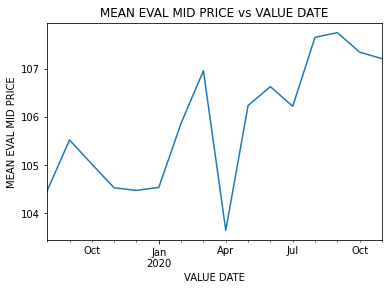

In [ ]:
general_stat["EVAL MID PRICE"].plot(ylabel="MEAN EVAL MID PRICE", title="MEAN EVAL MID PRICE vs VALUE DATE")

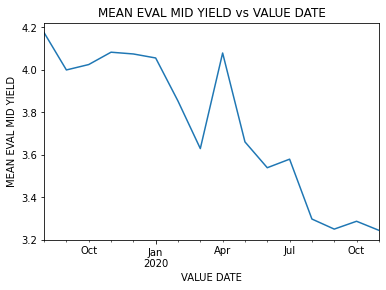

In [ ]:
general_stat["EVAL MID YIELD"].plot(ylabel="MEAN EVAL MID YIELD", title="MEAN EVAL MID YIELD vs VALUE DATE")

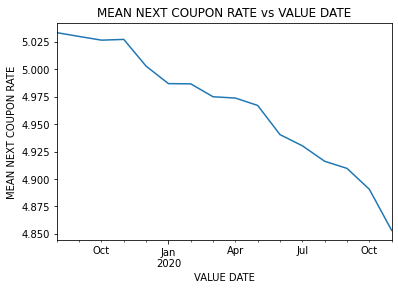

In [ ]:
general_stat["NEXT COUPON RATE"].plot(ylabel="MEAN NEXT COUPON RATE", title="MEAN NEXT COUPON RATE vs VALUE DATE")

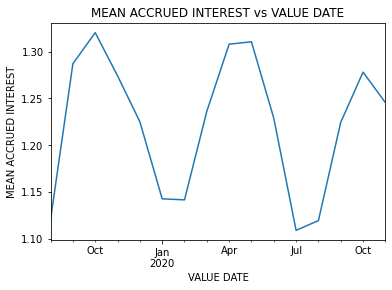

In [ ]:
general_stat["ACCRUED INTEREST"].plot(ylabel="MEAN ACCRUED INTEREST" ,title="MEAN ACCRUED INTEREST vs VALUE DATE")

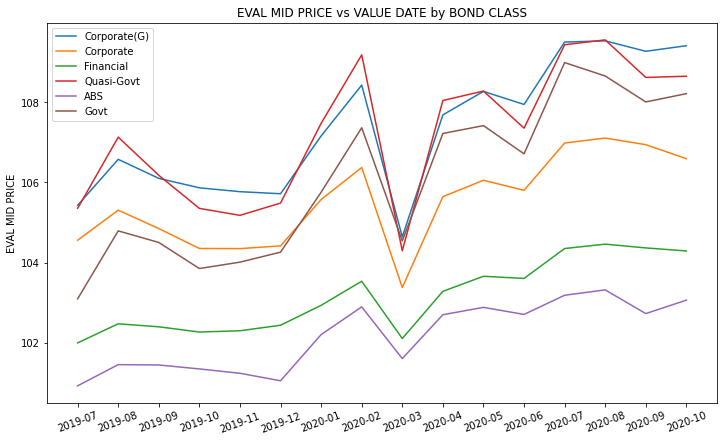

In [ ]:
# group by bond class
general_stat_by_bond_class = df_joined.groupby([df_joined["VALUE DATE"].dt.to_period('M'),df_joined["BOND CLASS"]]).mean()
plt.figure(figsize=(12,7))
for bond_class in df_joined["BOND CLASS"].unique():
  general_stat_by_bond_class[general_stat_by_bond_class.index.get_level_values('BOND CLASS') == bond_class]["EVAL MID PRICE"].plot(ylabel="EVAL MID PRICE", label=bond_class, use_index=False)

labels = general_stat_by_bond_class.index.get_level_values('VALUE DATE').unique() - 1 # because value date is the early of next month
ticks = [i for i in range(len(labels))]
plt.title("EVAL MID PRICE vs VALUE DATE by BOND CLASS")
plt.xticks(ticks, labels, rotation=20)
plt.legend()

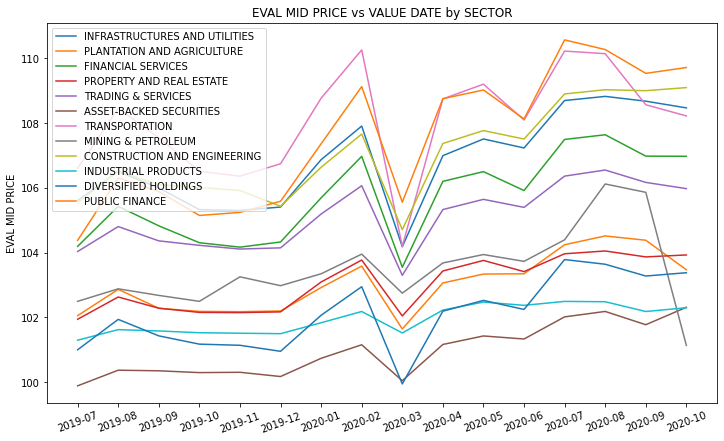

In [ ]:
# group by sector
general_stat_by_sector = df_joined.groupby([df_joined["VALUE DATE"].dt.to_period('M'),df_joined["SECTOR"]]).mean()
plt.figure(figsize=(12,7))
for sector in df_joined["SECTOR"].unique():
  general_stat_by_sector[general_stat_by_sector.index.get_level_values('SECTOR') == sector]["EVAL MID PRICE"].plot(ylabel="EVAL MID PRICE", label=sector, use_index=False)

labels = general_stat_by_sector.index.get_level_values('VALUE DATE').unique() - 1 # because value date is the early of next month
ticks = [i for i in range(len(labels))]
plt.title("EVAL MID PRICE vs VALUE DATE by SECTOR")
plt.xticks(ticks, labels, rotation=20)
plt.legend()

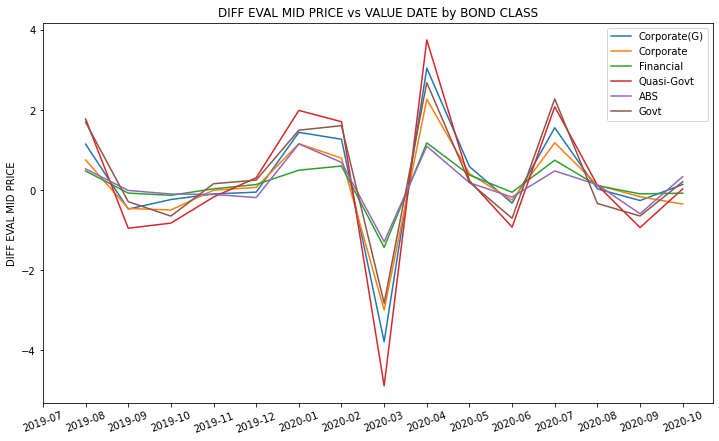

In [ ]:
# group by bond class
general_stat_by_bond_class = df_joined.groupby([df_joined["VALUE DATE"].dt.to_period('M'),df_joined["BOND CLASS"]]).mean()
plt.figure(figsize=(12,7))
for bond_class in df_joined["BOND CLASS"].unique():
  df_temp = general_stat_by_bond_class[general_stat_by_bond_class.index.get_level_values('BOND CLASS') == bond_class]["EVAL MID PRICE"]
  df_temp.diff().plot(ylabel="DIFF EVAL MID PRICE", label=bond_class, use_index=False)

labels = general_stat_by_bond_class.index.get_level_values('VALUE DATE').unique() - 1 # because value date is the early of next month
ticks = [i for i in range(len(labels))]
plt.title("DIFF EVAL MID PRICE vs VALUE DATE by BOND CLASS")
plt.xticks(ticks, labels, rotation=20)
plt.legend()

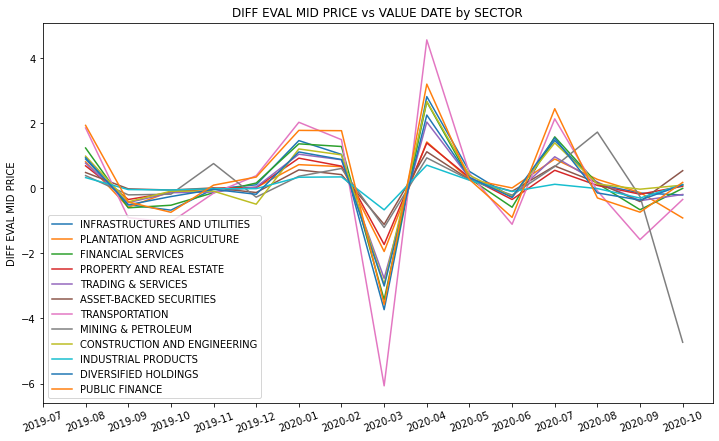

In [ ]:
# group by sector
general_stat_by_sector = df_joined.groupby([df_joined["VALUE DATE"].dt.to_period('M'),df_joined["SECTOR"]]).mean()
plt.figure(figsize=(12,7))
for sector in df_joined["SECTOR"].unique():
  df_temp = general_stat_by_sector[general_stat_by_sector.index.get_level_values('SECTOR') == sector]["EVAL MID PRICE"]
  df_temp.diff().plot(ylabel="DIFF EVAL MID PRICE", label=sector, use_index=False)

labels = general_stat_by_sector.index.get_level_values('VALUE DATE').unique() - 1 # because value date is the early of next month
ticks = [i for i in range(len(labels))]
plt.title("DIFF EVAL MID PRICE vs VALUE DATE by SECTOR")
plt.xticks(ticks, labels, rotation=20)
plt.legend()

# Feature Selection

### General Statistic

In [ ]:
for i in range(12,0,-1):
	general_stat['EVAL MID PRICE t-'+str(i)] = general_stat["EVAL MID PRICE"].shift(i)

general_stat

In [ ]:
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(general_stat.iloc[12:,28:], general_stat.iloc[12:,4])
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = general_stat.iloc[12:,28:].columns
ticks = [i for i in range(len(names))]
plt.figure(figsize=(20,5))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names, rotation=20)
plt.show()

In [ ]:
df_joined[df_joined["BOND CLASS"]=="PT140011"].plot(x ="VALUE DATE", y="EVAL MID PRICE")

In [ ]:
df_joined[df_joined["STOCK CODE"]=="PT140011"].plot(x = "VALUE DATE", y="EVAL MID PRICE")

In [ ]:
plot_acf(df_joined[df_joined["STOCK CODE"]=="PT140011"]["EVAL MID PRICE"])

In [ ]:
plt.acorr(df_joined[df_joined["STOCK CODE"]=="PT140011"]["EVAL MID PRICE"], maxlags=9)

# Modelling

### Given current month, predict next month bond price

In [ ]:
# assign target
data = pd.DataFrame()
for stock_code in df_joined["STOCK CODE"].unique():
  df_temp = df_joined[df_joined["STOCK CODE"]==stock_code].sort_values(["VALUE DATE"])
  df_temp["NEXT MONTH EVAL MID PRICE"] = df_temp["EVAL MID PRICE"].shift(-1)
  data = pd.concat([data, df_temp.iloc[:-1,:]], ignore_index=True)

data

In [ ]:
# one hot encoding
def preprocessing(data):
  cat_columns = ["PRINCIPLE", "BOND TYPE", "BOND CLASS", "RATING", "RATING AGENCY", "REMAINING TENURE", "ISLAMIC CONCEPT", "SECTOR", "RATING ACTION"]
  cat_columns_ohe = pd.get_dummies(data[cat_columns], drop_first=True)

  numerical_columns = data.select_dtypes(exclude=["category","datetime64[ns]"]).drop(["NEXT MONTH EVAL MID PRICE"], axis=1)
  numerical_columns["MATURITY DURATION"] = numerical_columns["MATURITY DURATION"].apply(lambda x: x.days)

  X = pd.concat([cat_columns_ohe, numerical_columns], axis=1)
  y = data["NEXT MONTH EVAL MID PRICE"]

  return X, y

X, y= preprocessing(data)

In [ ]:


# train test split by choosing future dates as the test set
test_split = data["VALUE DATE"] >= datetime.datetime(2020, 7, 1)
X_train, X_test, y_train, y_test = X[~test_split], X[test_split], y[~test_split], y[test_split]
print(test_split.value_counts(normalize=True))

# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X_train, y_train)

# plot importance scores
names = X_train.columns
tup_list = sorted(list(zip(names,model.feature_importances_)), key=lambda x: x[1])
names = [tup[0] for tup in tup_list]
fea_imp = [tup[1] for tup in tup_list]
ticks = [i for i in range(len(names))]
plt.figure(figsize=(5,40))
plt.barh(names, fea_imp)
plt.yticks(ticks, names)
plt.show()

In [ ]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [ ]:
print('Training set metrics:')
print('rmse:', rmse(y_train, model.predict(X_train)))

print('Test set metrics:')
print('rmse:', rmse(y_test, model.predict(X_test)))

In [ ]:
# Govt
X, y= preprocessing(data[data["STOCK CODE"] == "MX170003"].sort_values("VALUE DATE"))
plt.plot(y.values, color="blue", label="y_true")
plt.plot(model.predict(X), color="orange",  label="y_pred")
plt.legend()

In [ ]:
# Corporate(G)
X, y= preprocessing(data[data["STOCK CODE"] == "PT140011"].sort_values("VALUE DATE"))
plt.plot(y.values, color="blue", label="y_true")
plt.plot(model.predict(X), color="orange",  label="y_pred")
plt.legend()

In [ ]:
# Financial 
X, y= preprocessing(data[data["STOCK CODE"] == "UI180023"].sort_values("VALUE DATE"))
plt.plot(y.values, color="blue", label="y_true")
plt.plot(model.predict(X), color="orange",  label="y_pred")
plt.legend()

In [ ]:
data[data["MATURITY DURATION"].dt.days == 58]

In [ ]:
data["MATURITY DURATION"].value_counts()